# Caso completo sin AutoML

## El problema: Customer Churn

![](https://chartmogul.com/blog/wp-content/uploads/2022/02/blogWhat_s-a-good-Customer-Churn-Rate-1200x500.jpeg)

La rotación de clientes se define como cuando los clientes o suscriptores dejan de hacer negocios con una empresa o servicio.

Cada fila representa un cliente, cada columna contiene los atributos del cliente.

El conjunto de datos incluye información sobre:

- Clientes que se fueron en el último mes: la columna se llama **Churn**
- Servicios a los que se ha suscrito cada cliente: teléfono, líneas múltiples, Internet, seguridad en línea, respaldo en línea, protección de dispositivos, soporte técnico y transmisión de TV y películas.
- Información de la cuenta del cliente: cuánto tiempo ha sido cliente, contrato, método de pago, facturación electrónica, cargos mensuales y cargos totales
- Información demográfica sobre los clientes: género, rango de edad y si tienen parejas y dependientes

## Comprender el contexto empresarial y el problema

Después de esas reuniones tenemos que comprobar los datos existentes en la empresa y encontrar información útil en ellos. Supongamos que lo hicimos y después de un proceso de integración de datos creamos un conjunto de datos completo para nuestros clientes y su información. Recuerda que estamos trabajando con una empresa de telecomunicaciones.

## Librerías

In [32]:
!pip install datatable

In [33]:
!pip install seaborn --upgrade

In [1]:
import pandas as pd
import datatable as dt
from datatable import f
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import warnings
import numpy as np
warnings.filterwarnings("ignore")

## Cargar datos

In [2]:
df = dt.fread("data/churn_data.csv")

In [3]:
df.head()

<Frame#7f9c020cde10 10x21>

In [4]:
df.shape

(7043, 21)

El color significa el tipo de datos donde el rojo denota cadena, el verde denota int, el amarillo significa booleano y el azul significa flotador.

## ¿Cuántos clientes se han ido?

In [5]:
df[f.Churn == "Yes", dt.count()]

<Frame#7f9c020cde70 1x1>

In [6]:
1869/7043

0.2653698707936959

Se han ido 1869 clientes, eso significa el 26% de nuestros clientes. Entonces, si recordamos las métricas del negocio, tenemos un problema.

## ¿Cuánto dinero hemos perdido por la pérdida de clientes?

In [57]:
df[:, dt.count(), dt.by(dt.f.Churn)]

<Frame#7f9c03b70a50 2x2>

In [8]:
df[dt.f.Churn == 'Yes', 'TotalCharges'].sum1()

2862926.9000000027

Hemos perdido $2.862.926 debido a la rotación de clientes. Así que vamos a tratar de resolver este problema.

## EDA

In [9]:
df_pandas = df.to_pandas()

In [10]:
df_pandas.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female          False     Yes         No       1           No   
1  5575-GNVDE    Male          False      No         No      34          Yes   
2  3668-QPYBK    Male          False      No         No       2          Yes   
3  7795-CFOCW    Male          False      No         No      45           No   
4  9237-HQITU  Female          False      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

In [58]:
def diagnostic_plots(df, variable):
    
    plt.figure(figsize=(20, 9))

    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [59]:
num_columns=df_pandas.select_dtypes(include=["number"]).columns
num_columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

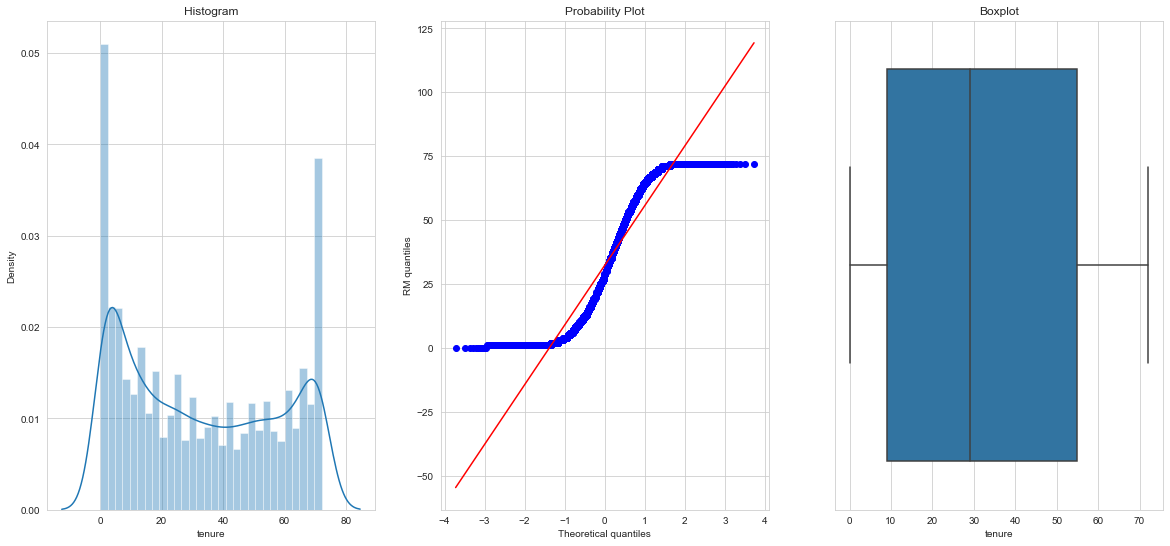

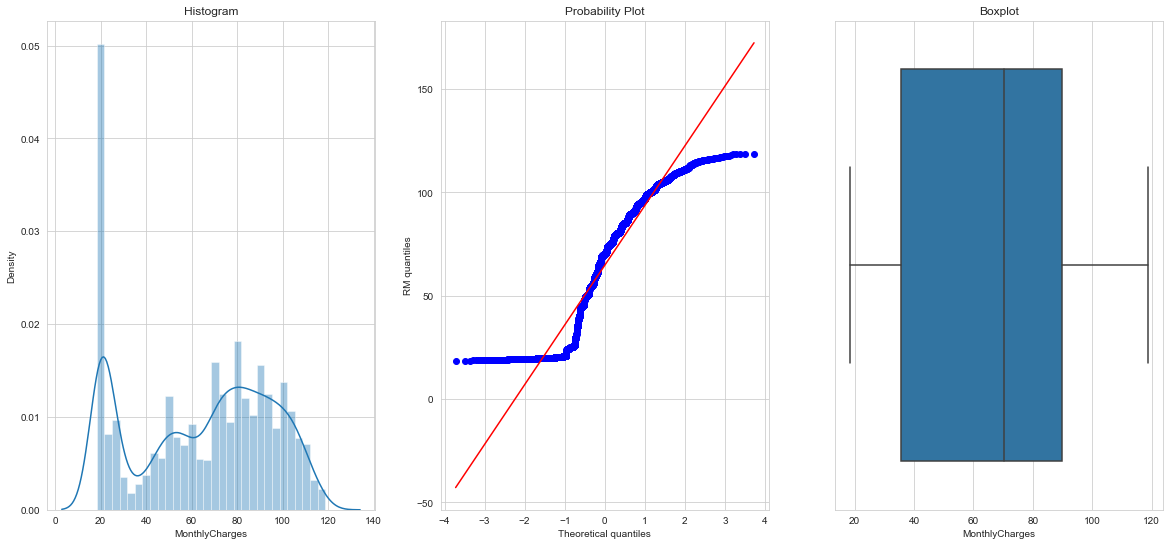

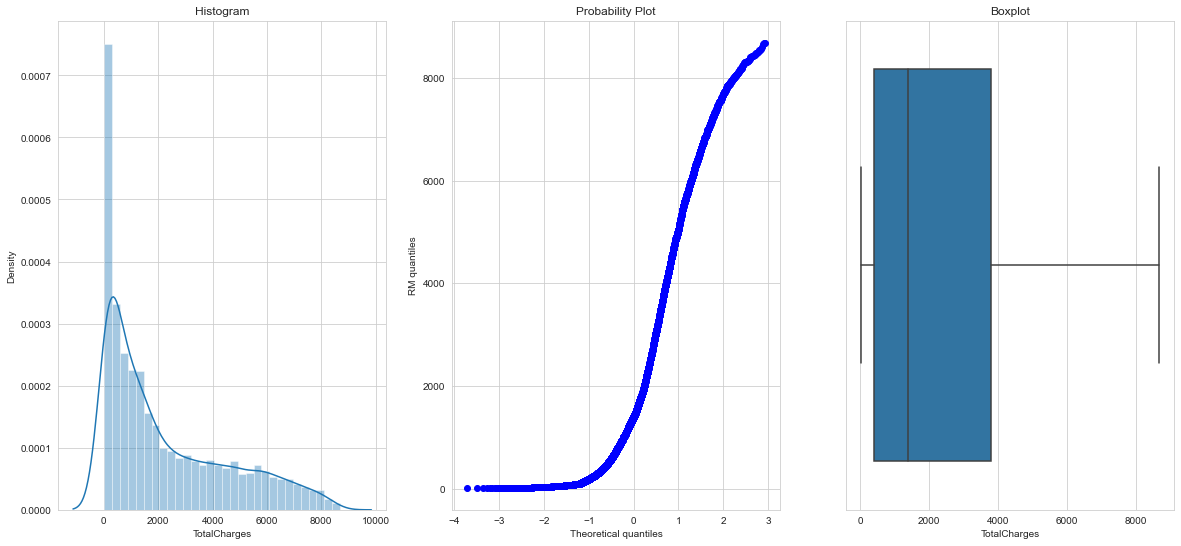

In [60]:
for i in num_columns:
    diagnostic_plots(df_pandas,i)

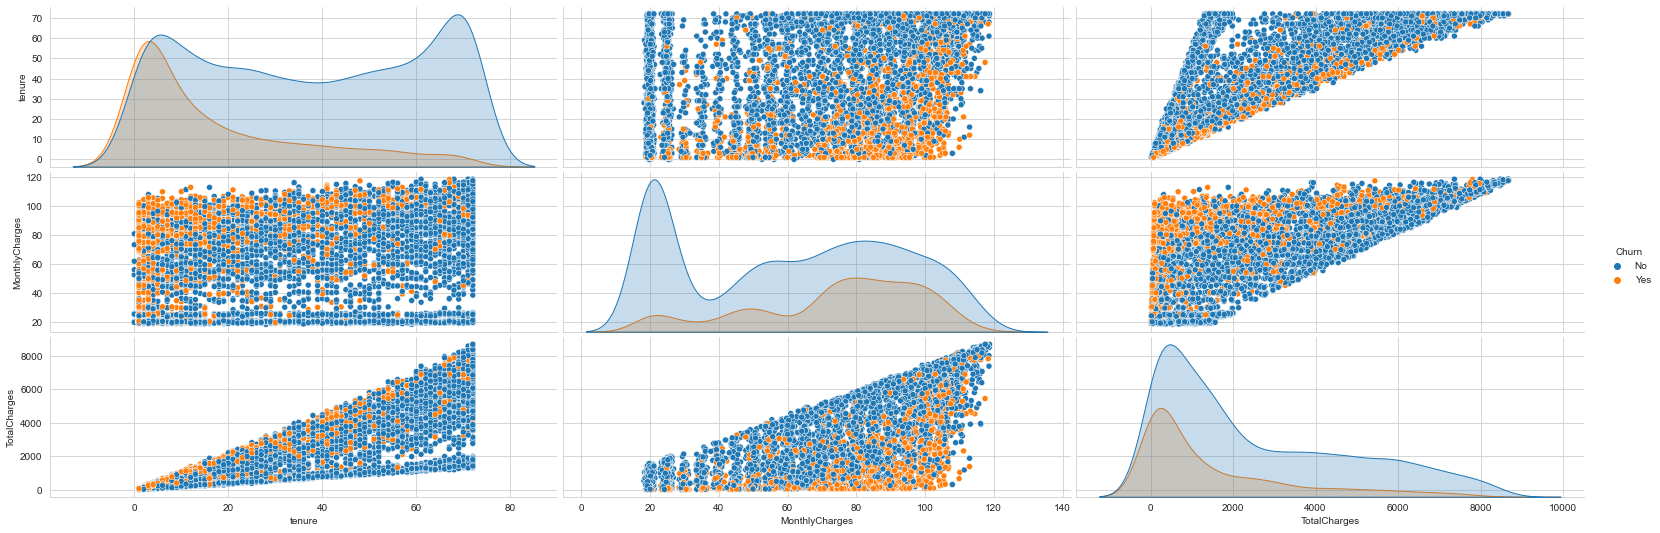

In [14]:
sns.pairplot(df_pandas.drop("SeniorCitizen",axis=1),hue="Churn",aspect=3);

In [15]:
fig = px.histogram(df_pandas, x="Churn")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [16]:
fig = px.histogram(df_pandas, x="Churn", color="SeniorCitizen")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [17]:
fig = px.histogram(df_pandas, x="Churn", color="OnlineSecurity", barmode="group")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [18]:
fig = px.box(df_pandas, x='Churn', y = 'tenure')
fig.show()

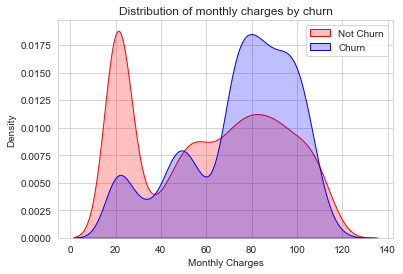

In [19]:
ax = sns.kdeplot(df_pandas.MonthlyCharges[(df_pandas["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(df_pandas.MonthlyCharges[(df_pandas["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

In [20]:
corr = df_pandas.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

heat = go.Heatmap(
    z=corr.mask(mask),
    x=corr.columns,
    y=corr.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1
)

pio.templates.default = "plotly_white"


fig.update_xaxes(side="bottom")

fig.update_layout(
    title_text='Heatmap', 
    title_x=0.5, 
    width=1000, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

fig=go.Figure(data=[heat])
fig.show()

## Limpieza de datos

In [21]:
df.names

('customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn')

In [22]:
df.stypes

(stype.str32,
 stype.str32,
 stype.bool8,
 stype.str32,
 stype.str32,
 stype.int32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.float64,
 stype.float64,
 stype.str32)

In [23]:
##missing values
dt.math.isna(df).sum()

<Frame#7f9bd0e74ba0 1x21>

We only have 11 missing values in the TotalCharges column. 

In [24]:
##Delete missing rows
df = df[dt.rowall(dt.f[:] != None), :]

In [25]:
#Delete customerID
del df[:, "customerID"]

In [26]:
df.head()

<Frame#7f9bd0e74750 10x20>

In [27]:
#Enconde Churn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[:, 'Churn'] = dt.Frame(le.fit_transform(np.ravel(df[:, 'Churn'])))

In [28]:
# Function for OHE
def ohe_columns(columns,df):
    df_work = df.copy()
    for column in columns:
        df_ohe = dt.str.split_into_nhot(df_work[column])
        df_ohe.names = [f'{column}_{col}' for col in df_ohe.names]
        df_work.cbind(df_ohe)
    return df_work

In [29]:
# Select categorical columns
categorical_columns = df[:, str].names

In [30]:
# Get final df after OHE
df_final = ohe_columns(categorical_columns,df)

In [31]:
# Delete original columns
del df_final[:, categorical_columns]

In [32]:
df_final.head()

<Frame#7f9bf1270ae0 10x46>

## Modelado

### H2O

In [36]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o --user

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.1 MB 106 kB/s eta 0:00:011
  Using cached tabulate-0.8.10-py3-none-any.whl (29 kB)
  Using cached future-0.18.2.tar.gz (829 kB)
  Created wheel for h2o: filename=h2o-3.36.1.4-py2.py3-none-any.whl size=177128127 sha256=b5d50134c95735e2fc3c007fc55d69dfb636c9061d70894c05eea0501c46e30e
  Stored in directory: /Users/faviovazquez/Library/Caches/pip/wheels/73/be/32/5fbb816a1676d34d283e16a30aa9a59050bd74726045e13736
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=25a13d206402c9762bb6224cf917fa5230907d10c08b994de2c130b8f28a68e5
  Stored in directory: /Users/faviovazquez/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built h2o future
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to P

In [37]:
import h2o

In [38]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21); OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from /Users/faviovazquez/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tq/r93jj3350px50gv8j6t4w8xw0000gn/T/tmpd659ydhk
  JVM stdout: /var/folders/tq/r93jj3350px50gv8j6t4w8xw0000gn/T/tmpd659ydhk/h2o_faviovazquez_started_from_python.out
  JVM stderr: /var/folders/tq/r93jj3350px50gv8j6t4w8xw0000gn/T/tmpd659ydhk/h2o_faviovazquez_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/Mexico_City
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.4
H2O_cluster_version_age:    25 days
H2O_cluster_name:           H2O_from_python_faviovazquez_7g7uff
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    10 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.12 final
--------------------------  -----------------------------------

In [39]:
dataset = h2o.H2OFrame(df_final.to_pandas())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [40]:
dataset.head()

SeniorCitizen tenure MonthlyCharges TotalCharges Churn gender_Female gender_Male Partner_Yes Partner_No Dependents_No Dependents_Yes PhoneService_Yes PhoneService_No MultipleLines_No phone service MultipleLines_No MultipleLines_Yes InternetService_No InternetService_Fiber optic InternetService_DSL OnlineSecurity_No OnlineSecurity_No internet service OnlineSecurity_Yes OnlineBackup_No internet service OnlineBackup_No OnlineBackup_Yes DeviceProtection_No DeviceProtection_Yes DeviceProtection_No internet service TechSupport_No internet service TechSupport_Yes TechSupport_No StreamingTV_No StreamingTV_Yes StreamingTV_No internet service StreamingMovies_No StreamingMovies_Yes StreamingMovies_No internet service Contract_Month-to-month Contract_Two year Contract_One year PaperlessBilling_Yes PaperlessBilling_No PaymentMethod_Mailed check PaymentMethod_Credit card (automatic) PaymentMethod_Electronic check PaymentMethod_Bank transfer (automatic) 
 
 
 False 1 29.85 29.85 0 True False True False True False False True True False False False False True True False False False False True True False False False False True True False False True False False True False False True False False False True False 
 False 34 56.95 1889.5 0 False True False True True False True False False True False False False True False False True False True False False True False False False True True False False True False False False False True False True True False False False 
 False 2 53.85 108.15 1 False True False True True False True False False True False False False True False False True False False True True False False False False True True False False True False False True False False True False True False False False 
 False 45 42.3 1840.75 0 False True False True True False False True True False False False False True False False True False True False False True False False True False True False False True False False False False True False True False False False True 
 False 2 70.7 151.65 1 True False False True True False True False False True False False True False True False False False True False True False False False False True True False False True False False True False False True False False False True False 
 False 8 99.65 820.5 1 True False False True True False True False False False True False True False True False False False True False False True False False False True False True False False True False True False False True False False False True False 
 False 22 89.1 1949.4 0 False True False True False True True False False False True False True False True False False False False True True False False False False True False True False True False False True False False True False False True False False 
 False 10 29.75 301.9 0 True False False True True False False True True False False False False True False False True False True False True False False False False True True False False True False False True False False False True True False False False 
 False 28 104.8 3046.05 1 True False True False True False True False False False True False True False True False False False True False False True False False True False False True False False True False True False False True False False False True False 
 False 62 56.15 3487.95 0 False True False True False True True False False True False False False True False False True False False True True False False False False True True False False True False False False False True False True False False False True

### 2. GBM with H2O

In [43]:
from h2o.estimators import *
from h2o.grid import *

In [44]:
train, valid, test = dataset.split_frame([0.7, 0.15], seed=42)

In [45]:
# Identify predictors and response
x = train.columns
y = "Churn"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
valid[y] = valid[y].asfactor()

In [46]:
gbm = H2OGradientBoostingEstimator(seed = 42, 
                                   model_id = 'default_gbm')

%time gbm.train(x = x, y = y, training_frame = train, validation_frame = valid)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
CPU times: user 99.8 ms, sys: 19.2 ms, total: 119 ms
Wall time: 2.78 s
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              20225.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        18.0        32.0         27.5



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10958647430727853
RMSE: 0.33103847859014596
LogLoss: 0.3458136874723227
Mean Per-Class Error: 0.1738319200417736
AUC: 0.9054229000511663
AUCPR: 0.7824779042613199
Gini: 0.8108458001023326

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31346029915875223: 


0       1   Error             Rate
0      0  2947.0   672.0  0.1857   (672.0/3619.0)
1      1   213.0  1102.0   0.162   (213.0/1315.0)
2  Total  3160.0  1774.0  0.1794   (885.0/4934.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.313460     0.713500  226.0
1                        max f2   0.211887     0.807055  272.0
2                  max f0point5   0.511688     0.725440  145.0
3                  max accuracy   0.509240     0.845156  146.0
4                 max precision   0.950451     1.000000    0.0
5                    max recall   0.018067     1.000000  392.0
6               max specificity   0.950451     1.000000    0.0
7              max absolute_mcc   0.377166     0.602274  198.0
8    max min_per_class_accuracy   0.325187     0.822050  221.0
9   max mean_per_class_accuracy   0.292776     0.826382  235.0
10                      max tns   0.950451  3619.000000    0.0
11                      max fns   0.950451  1314.000000    0.0
12                      max fps   0.012380  3619.000000  399.0
13                      max tps   0.018067  1315.000000  392.0
14                      max tnr   0.950451     1.000000    0.0
15                      max fnr   0.950451     0.999240    0.0
16                      max fpr   0.012380     1.000000  399.0
17                      max tpr   0.018067     1.000000  392.0


Gains/Lift Table: Avg response rate: 26.65 %, avg score: 26.67 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010336         0.874890  3.752091   
1       2                  0.020065         0.853544  3.595754   
2       3                  0.029996         0.828912  3.522371   
3       4                  0.041143         0.801991  3.547432   
4       5                  0.050061         0.780773  3.325717   
5       6                  0.100122         0.669731  3.098893   
6       7                  0.149980         0.589494  2.577656   
7       8                  0.200041         0.527443  2.263407   
8       9                  0.299959         0.382310  1.811354   
9      10                  0.400081         0.266862  1.192466   
10     11                  0.500000         0.167530  0.646912   
11     12                  0.599919         0.102560  0.403369   
12     13                  0.700041         0.058654  0.113930   
13     14                  0.799959         0.030961  0.053275   
14     15                  0.899878         0.020592  0.022832   
15     16                  1.000000         0.011642  0.007595   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.752091       1.000000  0.894904                  1.000000   
1          3.676291       0.958333  0.864237                  0.979798   
2          3.625331       0.938776  0.840956                  0.966216   
3          3.604226       0.945455  0.814377                  0.960591   
4          3.554613       0.886364  0.792388                  0.947368   
5          3.326753       0.825911  0.724393                  0.886640   
6          3.077729       0.686992  0.628312                  0.820270   
7          2.873942       0.603239  0.557448                  0.765957   
8          2.519986       0.482759  0.454657                  0.671622   
9          2.187770       0.317814  0.323052                  0.583080   
10         1.879848       0.172414  0.214699                  0.501013   
11         1.633934       0.107505  0.131990                  0.435473   
12         1.416539       0.030364  0.080813                  0.377533   
13         1.246261       0.014199  0.043382                  0.332151   
14         1.110416       0.006085  0.025324                  0.295946   
15         1.000000       0.002024  0.016890                  0.266518   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.894904      0.038783                 0.038783  275.209125   
1           0.880035      0.034981                 0.073764  259.575412   
2           0.867097      0.034981                 0.108745  252.237138   
3           0.852813      0.039544                 0.148289  254.743173   
4           0.842049      0.029658                 0.177947  232.571725   
5           0.783221      0.155133                 0.333080  209.889318   
6           0.731724      0.128517                 0.461597  157.765619   
7           0.688111      0.113308                 0.574905  126.340728   
8           0.610346      0.180989                 0.755894   81.135440   
9           0.538449      0.119392                 0.875285   19.246625   
10          0.473752      0.064639                 0.939924  -35.308771   
11          0.416830      0.040304                 0.980228  -59.663116   
12          0.368772      0.011407                 0.991635  -88.607010   
13          0.328129      0.005323                 0.996958  -94.672487   
14          0.294507      0.002281                 0.999240  -97.716780   
15          0.266711      0.000760                 1.000000  -99.240467   

    cumulative_gain  kolmogorov_smirnov  
0        275.209125            0.038783  
1        267.629143            0.073212  
2        262.533142            0.107364  
3        260.422559            0.146078  
4        255.461277            0.174355  
5        232.675297            0.317606  
6        207.772891            0.424846  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.12842548501147677
RMSE: 0.358365016444793
LogLoss: 0.3988696448831624
Mean Per-Class Error: 0.2219896172884221
AUC: 0.861661233852469
AUCPR: 0.6907080768506009
Gini: 0.7233224677049379

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3801799029679338: 


0      1   Error             Rate
0      0  635.0  118.0  0.1567    (118.0/753.0)
1      1   79.0  196.0  0.2873     (79.0/275.0)
2  Total  714.0  314.0  0.1916   (197.0/1028.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.380180    0.665535  186.0
1                        max f2   0.098687    0.767442  320.0
2                  max f0point5   0.639694    0.658409   78.0
3                  max accuracy   0.517788    0.813230  132.0
4                 max precision   0.932091    1.000000    0.0
5                    max recall   0.020106    1.000000  390.0
6               max specificity   0.932091    1.000000    0.0
7              max absolute_mcc   0.389955    0.535401  181.0
8    max min_per_class_accuracy   0.296804    0.778220  222.0
9   max mean_per_class_accuracy   0.292639    0.784810  224.0
10                      max tns   0.932091  753.000000    0.0
11                      max fns   0.932091  274.000000    0.0
12                      max fps   0.012320  753.000000  399.0
13                      max tps   0.020106  275.000000  390.0
14                      max tnr   0.932091    1.000000    0.0
15                      max fnr   0.932091    0.996364    0.0
16                      max fpr   0.012320    1.000000  399.0
17                      max tpr   0.020106    1.000000  390.0


Gains/Lift Table: Avg response rate: 26.75 %, avg score: 27.14 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010700         0.874002  3.058512   
1       2                  0.020428         0.862832  2.990545   
2       3                  0.030156         0.842127  3.738182   
3       4                  0.040856         0.823978  3.398347   
4       5                  0.050584         0.801560  3.364364   
5       6                  0.100195         0.663838  2.931907   
6       7                  0.150778         0.600756  2.228531   
7       8                  0.200389         0.547149  1.832442   
8       9                  0.300584         0.387377  1.887237   
9      10                  0.399805         0.268359  1.026168   
10     11                  0.500000         0.173278  0.798447   
11     12                  0.600195         0.098807  0.689568   
12     13                  0.699416         0.065487  0.219893   
13     14                  0.799611         0.036001  0.036293   
14     15                  0.899805         0.023103  0.145172   
15     16                  1.000000         0.012097  0.036293   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.058512       0.818182  0.890218                  0.818182   
1          3.026147       0.800000  0.868248                  0.809524   
2          3.255836       1.000000  0.849269                  0.870968   
3          3.293160       0.909091  0.835022                  0.880952   
4          3.306853       0.900000  0.811062                  0.884615   
5          3.121200       0.784314  0.733735                  0.834951   
6          2.821724       0.596154  0.630294                  0.754839   
7          2.576805       0.490196  0.572785                  0.689320   
8          2.346949       0.504854  0.470096                  0.627832   
9          2.019164       0.274510  0.325767                  0.540146   
10         1.774545       0.213592  0.216026                  0.474708   
11         1.593423       0.184466  0.128248                  0.426256   
12         1.398569       0.058824  0.082452                  0.374131   
13         1.227870       0.009709  0.048952                  0.328467   
14         1.107310       0.038835  0.028260                  0.296216   
15         1.000000       0.009709  0.018068                  0.267510   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.890218      0.032727                 0.032727  205.851240   
1           0.879756      0.029091                 0.061818  199.054545   
2           0.869922      0.036364                 0.098182  273.818182   
3           0.860781      0.036364                 0.134545  239.834711   
4           0.851220      0.032727                 0.167273  236.436364   
5           0.793048      0.145455                 0.312727  193.190731   
6           0.738447      0.112727                 0.425455  122.853147   
7           0.697433      0.090909                 0.516364   83.244207   
8           0.621654      0.189091                 0.705455   88.723742   
9           0.548222      0.101818                 0.807273    2.616756   
10          0.481654      0.080000                 0.887273  -20.155340   
11          0.422657      0.069091                 0.956364  -31.043248   
12          0.374394      0.021818                 0.978182  -78.010695   
13          0.333615      0.003636                 0.981818  -96.370697   
14          0.299613      0.014545                 0.996364  -85.482789   
15          0.271404      0.003636                 1.000000  -96.370697   

    cumulative_gain  kolmogorov_smirnov  
0        205.851240            0.030071  
1        202.614719            0.056506  
2        225.583578            0.092870  
3        229.316017            0.127905  
4        230.685315            0.159305  
5        212.120035            0.290151  
6        182.172434            0.374990  
7        1



Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-08-29 07:40:37   0.116 sec              0.0       0.442138   
1     2022-08-29 07:40:37   0.368 sec              1.0       0.428157   
2     2022-08-29 07:40:37   0.441 sec              2.0       0.416530   
3     2022-08-29 07:40:37   0.475 sec              3.0       0.406831   
4     2022-08-29 07:40:37   0.511 sec              4.0       0.398719   
5     2022-08-29 07:40:37   0.552 sec              5.0       0.391776   
6     2022-08-29 07:40:37   0.584 sec              6.0       0.385798   
7     2022-08-29 07:40:37   0.621 sec              7.0       0.380729   
8     2022-08-29 07:40:37   0.672 sec              8.0       0.376257   
9     2022-08-29 07:40:37   0.741 sec              9.0       0.372506   
10    2022-08-29 07:40:37   0.781 sec             10.0       0.369335   
11    2022-08-29 07:40:37   0.827 sec             11.0       0.366521   
12    2022-08-29 07:40:37   0.873 sec             12.0       0.364072   
13    2022-08-29 07:40:38   0.949 sec             13.0       0.361965   
14    2022-08-29 07:40:38   1.108 sec             14.0       0.360045   
15    2022-08-29 07:40:38   1.318 sec             15.0       0.358093   
16    2022-08-29 07:40:38   1.367 sec             16.0       0.356263   
17    2022-08-29 07:40:38   1.398 sec             17.0       0.354757   
18    2022-08-29 07:40:38   1.428 sec             18.0       0.353553   
19    2022-08-29 07:40:38   1.456 sec             19.0       0.352240   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.579765      0.500000         0.266518       1.000000   
1           0.549240      0.854026         0.660216       3.176617   
2           0.525090      0.857407         0.671606       3.178523   
3           0.505477      0.860020         0.675066       3.178523   
4           0.489209      0.861474         0.680406       3.178523   
5           0.475334      0.863734         0.691403       3.528752   
6           0.463253      0.866597         0.694802       3.454306   
7           0.452913      0.868265         0.700247       3.541300   
8           0.443663      0.870707         0.701347       3.422960   
9           0.435767      0.872130         0.703877       3.444543   
10          0.428851      0.873249         0.706161       3.449503   
11          0.422717      0.874035         0.707615       3.391313   
12          0.417244      0.875726         0.711265       3.376882   
13          0.412373      0.876369         0.714256       3.526966   
14          0.407984      0.877453         0.716075       3.535624   
15          0.403746      0.878872         0.719790       3.678521   
16          0.399772      0.880245         0.723678       3.677049   
17          0.396412      0.881231         0.725561       3.677049   
18          0.393407      0.881983         0.726729       3.679936   
19          0.390588      0.883010         0.729286       3.677049   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.733482         0.442662            0.580769   
1                        0.235306         0.428250            0.549401   
2                        0.219092         0.416723            0.525606   
3                        0.224767         0.406935            0.506025   
4                        0.220916         0.399229            0.490638   
5                        0.230442         0.392616            0.477572   
6                        0.229834         0.387265            0.466850   
7                        0.233887         0.382324            0.457008   
8                        0.232266         0.378298            0.448555   
9                        0.209566         0.375115            0.441841   
10                       0.213214         0.372462            0.435904   
11                       0.225578         0.370334            0.431254   
12                       0.221727         0.36824


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0          Contract_Month-to-month           792.393494           1.000000   
1                           tenure           301.986298           0.381106   
2                     TotalCharges           239.124710           0.301775   
3                   MonthlyCharges           225.380417           0.284430   
4      InternetService_Fiber optic           186.726349           0.235649   
5                OnlineSecurity_No           140.062210           0.176758   
6                   TechSupport_No            51.136436           0.064534   
7   PaymentMethod_Electronic check            41.864876           0.052833   
8                    SeniorCitizen            30.334711           0.038282   
9             PaperlessBilling_Yes            23.836893           0.030082   
10                MultipleLines_No            21.855917           0.027582   
11               Contract_Two year            18.849283           0.023788   
12                   gender_Female            16.132690           0.020359   
13                PhoneService_Yes            15.022038           0.018958   
14                  StreamingTV_No            14.861512           0.018755   
15                 OnlineBackup_No            13.130253           0.016570   
16      PaymentMethod_Mailed check            12.292831           0.015514   
17              StreamingMovies_No            11.930899           0.015057   
18                   Dependents_No             9.770290           0.012330   
19                     Partner_Yes             8.645896           0.010911   

    percentage  
0     0.358508  
1     0.136630  
2     0.108189  
3     0.101970  
4     0.084482  
5     0.063369  
6     0.023136  
7     0.018941  
8     0.013725  
9     0.010785  
10    0.009888  
11    0.008528  
12    0.007299  
13    0.006797  
14    0.006724  
15    0.005941  
16    0.005562  
17    0.005398  
18    0.004420  
19    0.003912


See the whole table with table.as_data_frame()


In [47]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              20225.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        18.0        32.0         27.5



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10958647430727853
RMSE: 0.33103847859014596
LogLoss: 0.3458136874723227
Mean Per-Class Error: 0.1738319200417736
AUC: 0.9054229000511663
AUCPR: 0.7824779042613199
Gini: 0.8108458001023326

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31346029915875223: 


0       1   Error             Rate
0      0  2947.0   672.0  0.1857   (672.0/3619.0)
1      1   213.0  1102.0   0.162   (213.0/1315.0)
2  Total  3160.0  1774.0  0.1794   (885.0/4934.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.313460     0.713500  226.0
1                        max f2   0.211887     0.807055  272.0
2                  max f0point5   0.511688     0.725440  145.0
3                  max accuracy   0.509240     0.845156  146.0
4                 max precision   0.950451     1.000000    0.0
5                    max recall   0.018067     1.000000  392.0
6               max specificity   0.950451     1.000000    0.0
7              max absolute_mcc   0.377166     0.602274  198.0
8    max min_per_class_accuracy   0.325187     0.822050  221.0
9   max mean_per_class_accuracy   0.292776     0.826382  235.0
10                      max tns   0.950451  3619.000000    0.0
11                      max fns   0.950451  1314.000000    0.0
12                      max fps   0.012380  3619.000000  399.0
13                      max tps   0.018067  1315.000000  392.0
14                      max tnr   0.950451     1.000000    0.0
15                      max fnr   0.950451     0.999240    0.0
16                      max fpr   0.012380     1.000000  399.0
17                      max tpr   0.018067     1.000000  392.0


Gains/Lift Table: Avg response rate: 26.65 %, avg score: 26.67 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010336         0.874890  3.752091   
1       2                  0.020065         0.853544  3.595754   
2       3                  0.029996         0.828912  3.522371   
3       4                  0.041143         0.801991  3.547432   
4       5                  0.050061         0.780773  3.325717   
5       6                  0.100122         0.669731  3.098893   
6       7                  0.149980         0.589494  2.577656   
7       8                  0.200041         0.527443  2.263407   
8       9                  0.299959         0.382310  1.811354   
9      10                  0.400081         0.266862  1.192466   
10     11                  0.500000         0.167530  0.646912   
11     12                  0.599919         0.102560  0.403369   
12     13                  0.700041         0.058654  0.113930   
13     14                  0.799959         0.030961  0.053275   
14     15                  0.899878         0.020592  0.022832   
15     16                  1.000000         0.011642  0.007595   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.752091       1.000000  0.894904                  1.000000   
1          3.676291       0.958333  0.864237                  0.979798   
2          3.625331       0.938776  0.840956                  0.966216   
3          3.604226       0.945455  0.814377                  0.960591   
4          3.554613       0.886364  0.792388                  0.947368   
5          3.326753       0.825911  0.724393                  0.886640   
6          3.077729       0.686992  0.628312                  0.820270   
7          2.873942       0.603239  0.557448                  0.765957   
8          2.519986       0.482759  0.454657                  0.671622   
9          2.187770       0.317814  0.323052                  0.583080   
10         1.879848       0.172414  0.214699                  0.501013   
11         1.633934       0.107505  0.131990                  0.435473   
12         1.416539       0.030364  0.080813                  0.377533   
13         1.246261       0.014199  0.043382                  0.332151   
14         1.110416       0.006085  0.025324                  0.295946   
15         1.000000       0.002024  0.016890                  0.266518   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.894904      0.038783                 0.038783  275.209125   
1           0.880035      0.034981                 0.073764  259.575412   
2           0.867097      0.034981                 0.108745  252.237138   
3           0.852813      0.039544                 0.148289  254.743173   
4           0.842049      0.029658                 0.177947  232.571725   
5           0.783221      0.155133                 0.333080  209.889318   
6           0.731724      0.128517                 0.461597  157.765619   
7           0.688111      0.113308                 0.574905  126.340728   
8           0.610346      0.180989                 0.755894   81.135440   
9           0.538449      0.119392                 0.875285   19.246625   
10          0.473752      0.064639                 0.939924  -35.308771   
11          0.416830      0.040304                 0.980228  -59.663116   
12          0.368772      0.011407                 0.991635  -88.607010   
13          0.328129      0.005323                 0.996958  -94.672487   
14          0.294507      0.002281                 0.999240  -97.716780   
15          0.266711      0.000760                 1.000000  -99.240467   

    cumulative_gain  kolmogorov_smirnov  
0        275.209125            0.038783  
1        267.629143            0.073212  
2        262.533142            0.107364  
3        260.422559            0.146078  
4        255.461277            0.174355  
5        232.675297            0.317606  
6        207.772891            0.424846  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.12842548501147677
RMSE: 0.358365016444793
LogLoss: 0.3988696448831624
Mean Per-Class Error: 0.2219896172884221
AUC: 0.861661233852469
AUCPR: 0.6907080768506009
Gini: 0.7233224677049379

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3801799029679338: 


0      1   Error             Rate
0      0  635.0  118.0  0.1567    (118.0/753.0)
1      1   79.0  196.0  0.2873     (79.0/275.0)
2  Total  714.0  314.0  0.1916   (197.0/1028.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.380180    0.665535  186.0
1                        max f2   0.098687    0.767442  320.0
2                  max f0point5   0.639694    0.658409   78.0
3                  max accuracy   0.517788    0.813230  132.0
4                 max precision   0.932091    1.000000    0.0
5                    max recall   0.020106    1.000000  390.0
6               max specificity   0.932091    1.000000    0.0
7              max absolute_mcc   0.389955    0.535401  181.0
8    max min_per_class_accuracy   0.296804    0.778220  222.0
9   max mean_per_class_accuracy   0.292639    0.784810  224.0
10                      max tns   0.932091  753.000000    0.0
11                      max fns   0.932091  274.000000    0.0
12                      max fps   0.012320  753.000000  399.0
13                      max tps   0.020106  275.000000  390.0
14                      max tnr   0.932091    1.000000    0.0
15                      max fnr   0.932091    0.996364    0.0
16                      max fpr   0.012320    1.000000  399.0
17                      max tpr   0.020106    1.000000  390.0


Gains/Lift Table: Avg response rate: 26.75 %, avg score: 27.14 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010700         0.874002  3.058512   
1       2                  0.020428         0.862832  2.990545   
2       3                  0.030156         0.842127  3.738182   
3       4                  0.040856         0.823978  3.398347   
4       5                  0.050584         0.801560  3.364364   
5       6                  0.100195         0.663838  2.931907   
6       7                  0.150778         0.600756  2.228531   
7       8                  0.200389         0.547149  1.832442   
8       9                  0.300584         0.387377  1.887237   
9      10                  0.399805         0.268359  1.026168   
10     11                  0.500000         0.173278  0.798447   
11     12                  0.600195         0.098807  0.689568   
12     13                  0.699416         0.065487  0.219893   
13     14                  0.799611         0.036001  0.036293   
14     15                  0.899805         0.023103  0.145172   
15     16                  1.000000         0.012097  0.036293   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.058512       0.818182  0.890218                  0.818182   
1          3.026147       0.800000  0.868248                  0.809524   
2          3.255836       1.000000  0.849269                  0.870968   
3          3.293160       0.909091  0.835022                  0.880952   
4          3.306853       0.900000  0.811062                  0.884615   
5          3.121200       0.784314  0.733735                  0.834951   
6          2.821724       0.596154  0.630294                  0.754839   
7          2.576805       0.490196  0.572785                  0.689320   
8          2.346949       0.504854  0.470096                  0.627832   
9          2.019164       0.274510  0.325767                  0.540146   
10         1.774545       0.213592  0.216026                  0.474708   
11         1.593423       0.184466  0.128248                  0.426256   
12         1.398569       0.058824  0.082452                  0.374131   
13         1.227870       0.009709  0.048952                  0.328467   
14         1.107310       0.038835  0.028260                  0.296216   
15         1.000000       0.009709  0.018068                  0.267510   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.890218      0.032727                 0.032727  205.851240   
1           0.879756      0.029091                 0.061818  199.054545   
2           0.869922      0.036364                 0.098182  273.818182   
3           0.860781      0.036364                 0.134545  239.834711   
4           0.851220      0.032727                 0.167273  236.436364   
5           0.793048      0.145455                 0.312727  193.190731   
6           0.738447      0.112727                 0.425455  122.853147   
7           0.697433      0.090909                 0.516364   83.244207   
8           0.621654      0.189091                 0.705455   88.723742   
9           0.548222      0.101818                 0.807273    2.616756   
10          0.481654      0.080000                 0.887273  -20.155340   
11          0.422657      0.069091                 0.956364  -31.043248   
12          0.374394      0.021818                 0.978182  -78.010695   
13          0.333615      0.003636                 0.981818  -96.370697   
14          0.299613      0.014545                 0.996364  -85.482789   
15          0.271404      0.003636                 1.000000  -96.370697   

    cumulative_gain  kolmogorov_smirnov  
0        205.851240            0.030071  
1        202.614719            0.056506  
2        225.583578            0.092870  
3        229.316017            0.127905  
4        230.685315            0.159305  
5        212.120035            0.290151  
6        182.172434            0.374990  
7        1



Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-08-29 07:40:37   0.116 sec              0.0       0.442138   
1     2022-08-29 07:40:37   0.368 sec              1.0       0.428157   
2     2022-08-29 07:40:37   0.441 sec              2.0       0.416530   
3     2022-08-29 07:40:37   0.475 sec              3.0       0.406831   
4     2022-08-29 07:40:37   0.511 sec              4.0       0.398719   
5     2022-08-29 07:40:37   0.552 sec              5.0       0.391776   
6     2022-08-29 07:40:37   0.584 sec              6.0       0.385798   
7     2022-08-29 07:40:37   0.621 sec              7.0       0.380729   
8     2022-08-29 07:40:37   0.672 sec              8.0       0.376257   
9     2022-08-29 07:40:37   0.741 sec              9.0       0.372506   
10    2022-08-29 07:40:37   0.781 sec             10.0       0.369335   
11    2022-08-29 07:40:37   0.827 sec             11.0       0.366521   
12    2022-08-29 07:40:37   0.873 sec             12.0       0.364072   
13    2022-08-29 07:40:38   0.949 sec             13.0       0.361965   
14    2022-08-29 07:40:38   1.108 sec             14.0       0.360045   
15    2022-08-29 07:40:38   1.318 sec             15.0       0.358093   
16    2022-08-29 07:40:38   1.367 sec             16.0       0.356263   
17    2022-08-29 07:40:38   1.398 sec             17.0       0.354757   
18    2022-08-29 07:40:38   1.428 sec             18.0       0.353553   
19    2022-08-29 07:40:38   1.456 sec             19.0       0.352240   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.579765      0.500000         0.266518       1.000000   
1           0.549240      0.854026         0.660216       3.176617   
2           0.525090      0.857407         0.671606       3.178523   
3           0.505477      0.860020         0.675066       3.178523   
4           0.489209      0.861474         0.680406       3.178523   
5           0.475334      0.863734         0.691403       3.528752   
6           0.463253      0.866597         0.694802       3.454306   
7           0.452913      0.868265         0.700247       3.541300   
8           0.443663      0.870707         0.701347       3.422960   
9           0.435767      0.872130         0.703877       3.444543   
10          0.428851      0.873249         0.706161       3.449503   
11          0.422717      0.874035         0.707615       3.391313   
12          0.417244      0.875726         0.711265       3.376882   
13          0.412373      0.876369         0.714256       3.526966   
14          0.407984      0.877453         0.716075       3.535624   
15          0.403746      0.878872         0.719790       3.678521   
16          0.399772      0.880245         0.723678       3.677049   
17          0.396412      0.881231         0.725561       3.677049   
18          0.393407      0.881983         0.726729       3.679936   
19          0.390588      0.883010         0.729286       3.677049   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.733482         0.442662            0.580769   
1                        0.235306         0.428250            0.549401   
2                        0.219092         0.416723            0.525606   
3                        0.224767         0.406935            0.506025   
4                        0.220916         0.399229            0.490638   
5                        0.230442         0.392616            0.477572   
6                        0.229834         0.387265            0.466850   
7                        0.233887         0.382324            0.457008   
8                        0.232266         0.378298            0.448555   
9                        0.209566         0.375115            0.441841   
10                       0.213214         0.372462            0.435904   
11                       0.225578         0.370334            0.431254   
12                       0.221727         0.36824


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0          Contract_Month-to-month           792.393494           1.000000   
1                           tenure           301.986298           0.381106   
2                     TotalCharges           239.124710           0.301775   
3                   MonthlyCharges           225.380417           0.284430   
4      InternetService_Fiber optic           186.726349           0.235649   
5                OnlineSecurity_No           140.062210           0.176758   
6                   TechSupport_No            51.136436           0.064534   
7   PaymentMethod_Electronic check            41.864876           0.052833   
8                    SeniorCitizen            30.334711           0.038282   
9             PaperlessBilling_Yes            23.836893           0.030082   
10                MultipleLines_No            21.855917           0.027582   
11               Contract_Two year            18.849283           0.023788   
12                   gender_Female            16.132690           0.020359   
13                PhoneService_Yes            15.022038           0.018958   
14                  StreamingTV_No            14.861512           0.018755   
15                 OnlineBackup_No            13.130253           0.016570   
16      PaymentMethod_Mailed check            12.292831           0.015514   
17              StreamingMovies_No            11.930899           0.015057   
18                   Dependents_No             9.770290           0.012330   
19                     Partner_Yes             8.645896           0.010911   

    percentage  
0     0.358508  
1     0.136630  
2     0.108189  
3     0.101970  
4     0.084482  
5     0.063369  
6     0.023136  
7     0.018941  
8     0.013725  
9     0.010785  
10    0.009888  
11    0.008528  
12    0.007299  
13    0.006797  
14    0.006724  
15    0.005941  
16    0.005562  
17    0.005398  
18    0.004420  
19    0.003912


See the whole table with table.as_data_frame()


In [48]:
gbm.predict(valid)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict p0 p1 
 
 
 0 0.786485 0.213515 
 0 0.971643 0.0283568 
 1 0.505384 0.494616 
 0 0.933614 0.0663862 
 1 0.53764 0.46236 
 1 0.460609 0.539391 
 1 0.257495 0.742505 
 1 0.159393 0.840607 
 0 0.980031 0.0199693 
 1 0.428484 0.571516

In [49]:
default_gbm_per = gbm.model_performance(test)

In [50]:
default_gbm_per


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14199138674478035
RMSE: 0.3768174448519871
LogLoss: 0.4328544369808647
Mean Per-Class Error: 0.25166863776626835
AUC: 0.8272569090439488
AUCPR: 0.6382717144394484
Gini: 0.6545138180878975

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27920416455978786: 


0      1   Error             Rate
0      0  614.0  177.0  0.2238    (177.0/791.0)
1      1   78.0  201.0  0.2796     (78.0/279.0)
2  Total  692.0  378.0  0.2383   (255.0/1070.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.279204    0.611872  216.0
1                        max f2   0.066641    0.736900  339.0
2                  max f0point5   0.584208    0.614035   93.0
3                  max accuracy   0.584208    0.800935   93.0
4                 max precision   0.954251    1.000000    0.0
5                    max recall   0.012991    1.000000  398.0
6               max specificity   0.954251    1.000000    0.0
7              max absolute_mcc   0.279204    0.456198  216.0
8    max min_per_class_accuracy   0.248571    0.749104  229.0
9   max mean_per_class_accuracy   0.241663    0.751714  232.0
10                      max tns   0.954251  791.000000    0.0
11                      max fns   0.954251  278.000000    0.0
12                      max fps   0.011638  791.000000  399.0
13                      max tps   0.012991  279.000000  398.0
14                      max tnr   0.954251    1.000000    0.0
15                      max fnr   0.954251    0.996416    0.0
16                      max fpr   0.011638    1.000000  399.0
17                      max tpr   0.012991    1.000000  398.0


Gains/Lift Table: Avg response rate: 26.07 %, avg score: 24.84 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010280         0.874001  3.835125   
1       2                  0.020561         0.858506  3.137830   
2       3                  0.030841         0.824207  3.137830   
3       4                  0.040187         0.785064  3.451613   
4       5                  0.050467         0.752422  2.440534   
5       6                  0.100000         0.639462  2.387908   
6       7                  0.150467         0.572980  2.343688   
7       8                  0.200000         0.490201  1.591939   
8       9                  0.300000         0.343031  1.469534   
9      10                  0.400000         0.217588  1.397849   
10     11                  0.500000         0.152859  0.860215   
11     12                  0.600935         0.099501  0.745719   
12     13                  0.700000         0.050711  0.506526   
13     14                  0.800000         0.029321  0.143369   
14     15                  0.900000         0.019233  0.071685   
15     16                  1.000000         0.011435  0.035842   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.835125       1.000000  0.895191                  1.000000   
1          3.486478       0.818182  0.866876                  0.909091   
2          3.370262       0.818182  0.833745                  0.878788   
3          3.389181       0.900000  0.799271                  0.883721   
4          3.195938       0.636364  0.766238                  0.833333   
5          2.795699       0.622642  0.692145                  0.728972   
6          2.644093       0.611111  0.601708                  0.689441   
7          2.383513       0.415094  0.537058                  0.621495   
8          2.078853       0.383178  0.409553                  0.542056   
9          1.908602       0.364486  0.280729                  0.497664   
10         1.698925       0.224299  0.184604                  0.442991   
11         1.538822       0.194444  0.121606                  0.401244   
12         1.392729       0.132075  0.074107                  0.363151   
13         1.236559       0.037383  0.039335                  0.322430   
14         1.107129       0.018692  0.023883                  0.288681   
15         1.000000       0.009346  0.016386                  0.260748   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.895191      0.039427                 0.039427  283.512545   
1           0.881033      0.032258                 0.071685  213.782991   
2           0.865271      0.032258                 0.103943  213.782991   
3           0.849922      0.032258                 0.136201  245.161290   
4           0.832875      0.025090                 0.161290  144.053438   
5           0.763168      0.118280                 0.279570  138.790830   
6           0.709014      0.118280                 0.397849  134.368777   
7           0.666427      0.078853                 0.476703   59.193887   
8           0.580802      0.146953                 0.623656   46.953405   
9           0.505784      0.139785                 0.763441   39.784946   
10          0.441548      0.086022                 0.849462  -13.978495   
11          0.387809      0.075269                 0.924731  -25.428116   
12          0.343414      0.050179                 0.974910  -49.347400   
13          0.305404      0.014337                 0.989247  -85.663082   
14          0.274124      0.007168                 0.996416  -92.831541   
15          0.248350      0.003584                 1.000000  -96.415771   

    cumulative_gain  kolmogorov_smirnov  
0        283.512545            0.039427  
1        248.647768            0.069156  
2        237.026176            0.098886  
3        238.918063            0.129880  
4        219.593787            0.149912  
5        179.569892            0.242907  
6        164.409270            0.334638  
7        1

In [51]:
# Hyperparameter estimation

gbm = H2OGradientBoostingEstimator(ntrees = 500,
                                   learn_rate = 0.05,
                                   seed = 42,
                                   model_id = 'grid_gbm')

hyper_params_tune = {'max_depth' : [4, 5, 6, 7, 8],
                     'sample_rate': [x/100. for x in range(20,101)],
                     'col_sample_rate' : [x/100. for x in range(20,101)],
                     'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                     'col_sample_rate_change_per_level': [x/100. for x in range(90,111)]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 90,  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42}

random_grid = H2OGridSearch(model = gbm, hyper_params = hyper_params_tune,
                            grid_id = 'random_grid',
                            search_criteria = search_criteria_tune)

%time random_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
CPU times: user 783 ms, sys: 70.1 ms, total: 853 ms
Wall time: 1min 31s
      col_sample_rate  col_sample_rate_change_per_level  \
0                0.25                              0.90   
1                0.83                              1.02   
2                0.43                              0.95   
3                0.60                              0.96   
4                0.97                              1.10   
5                0.53                              0.93   
6                0.69                              1.04   
7                0.71                              0.99   
8                0.48                              0.98   
9                0.81                              0.97   
10               0.57                              0.95   
11               0.37                              1.02   
12               0.68                              0.91   
13     

In [52]:
sorted_random_search = random_grid.get_grid(sort_by = 'auc',decreasing = True)
sorted_random_search.sorted_metric_table()

col_sample_rate  col_sample_rate_change_per_level  \
0                0.25                              0.90   
1                0.83                              1.02   
2                0.60                              0.96   
3                0.43                              0.95   
4                0.97                              1.10   
5                0.53                              0.93   
6                0.48                              0.98   
7                0.71                              0.99   
8                0.69                              1.04   
9                0.37                              1.02   
10               0.57                              0.95   
11               0.81                              0.97   
12               0.67                              1.01   
13               0.68                              0.91   
14               0.25                              1.09   
15               0.44                              1.03   
16               0.74                              0.97   
17               0.70                              0.91   
18               0.36                              0.98   
19               0.61                              1.02   

    col_sample_rate_per_tree  max_depth  sample_rate             model_ids  \
0                       0.26        7.0         0.55   random_grid_model_4   
1                       0.32        4.0         0.97  random_grid_model_19   
2                       0.22        4.0         0.31   random_grid_model_7   
3                       0.45        4.0         0.53  random_grid_model_16   
4                       0.69        4.0         0.83  random_grid_model_14   
5                       0.80        5.0         0.24  random_grid_model_20   
6                       0.24        8.0         0.36  random_grid_model_15   
7                       0.23        7.0         0.99  random_grid_model_18   
8                       0.28        5.0         0.28  random_grid_model_11   
9                       0.29        8.0         0.56   random_grid_model_1   
10                      0.94        5.0         0.46  random_grid_model_13   
11                      0.78        5.0         0.38  random_grid_model_12   
12                      0.71        6.0         0.64   random_grid_model_3   
13                      0.52        6.0         0.57  random_grid_model_17   
14                      1.00        6.0         0.52   random_grid_model_9   
15                      0.67        6.0         0.27  random_grid_model_10   
16                      0.69        6.0         0.50   random_grid_model_6   
17                      0.55        7.0         0.43   random_grid_model_5   
18                      0.94        8.0         0.22   random_grid_model_2   
19                      0.81        7.0         0.41   random_grid_model_8   

         auc  
0   0.863178  
1   0.855572  
2   0.854611  
3   0.854509  
4   0.848275  
5   0.846993  
6   0.840787  
7   0.840751  
8   0.840200  
9   0.837672  
10  0.837262  
11  0.836924  
12  0.835195  
13  0.834966  
14  0.834562  
15  0.833290  
16  0.832080  
17  0.829753  
18  0.829497  
19  0.827261

In [53]:
tuned_gbm = sorted_random_search.models[0]

In [54]:
tuned_gbm_per = tuned_gbm.model_performance(test)
print(tuned_gbm_per.auc())

0.8300164484863314


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## random_grid_model_4


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2800889196921385: 


0      1   Error             Rate
0      0  611.0  180.0  0.2276    (180.0/791.0)
1      1   74.0  205.0  0.2652     (74.0/279.0)
2  Total  685.0  385.0  0.2374   (254.0/1070.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

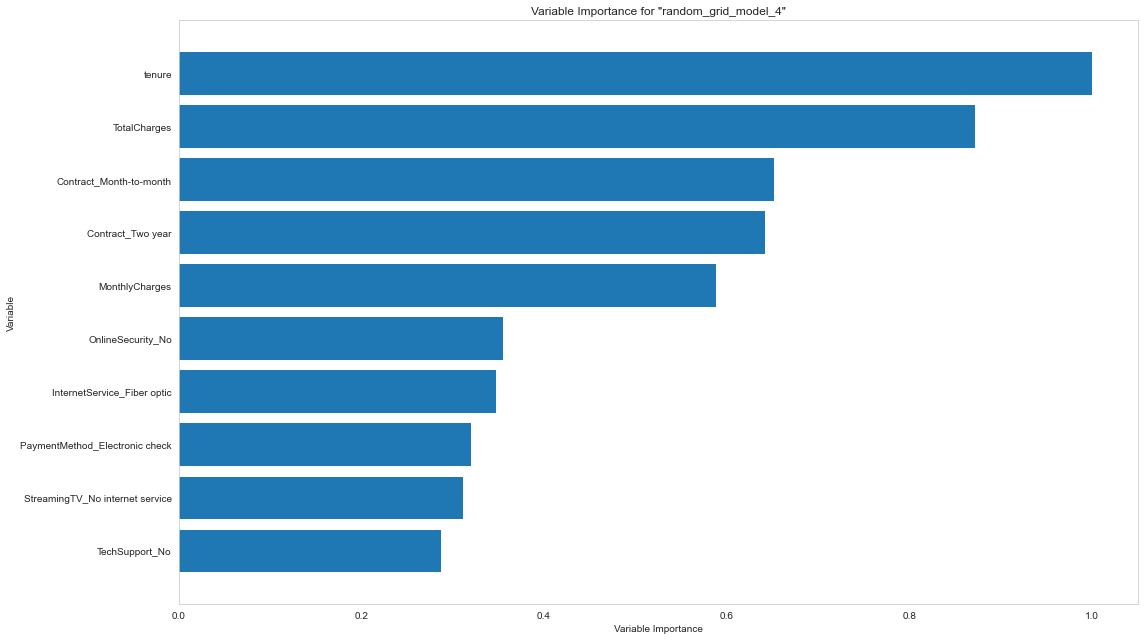

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

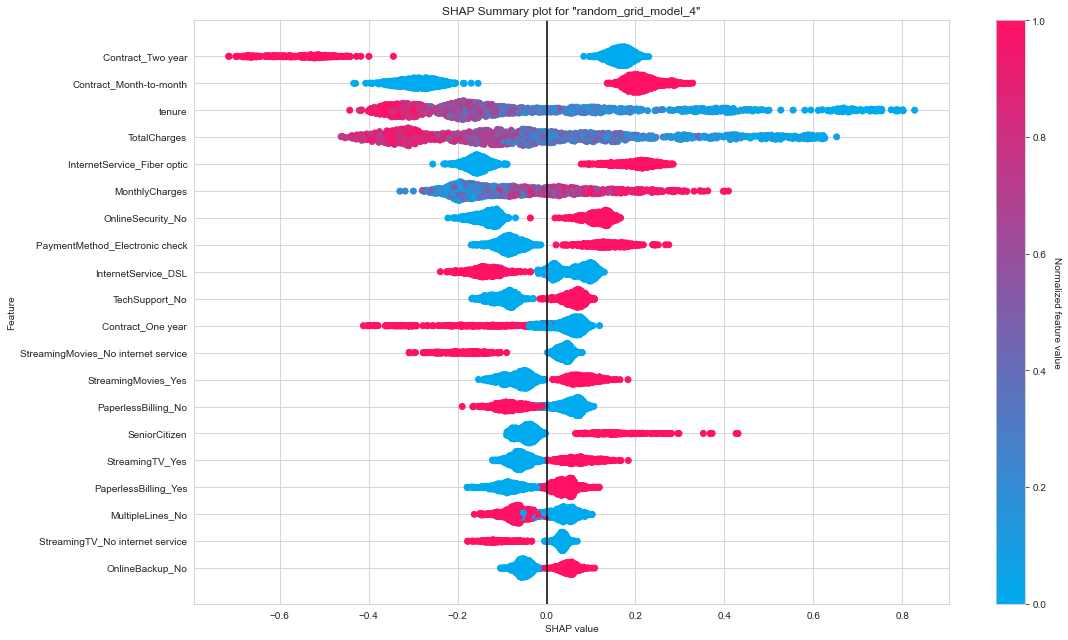

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

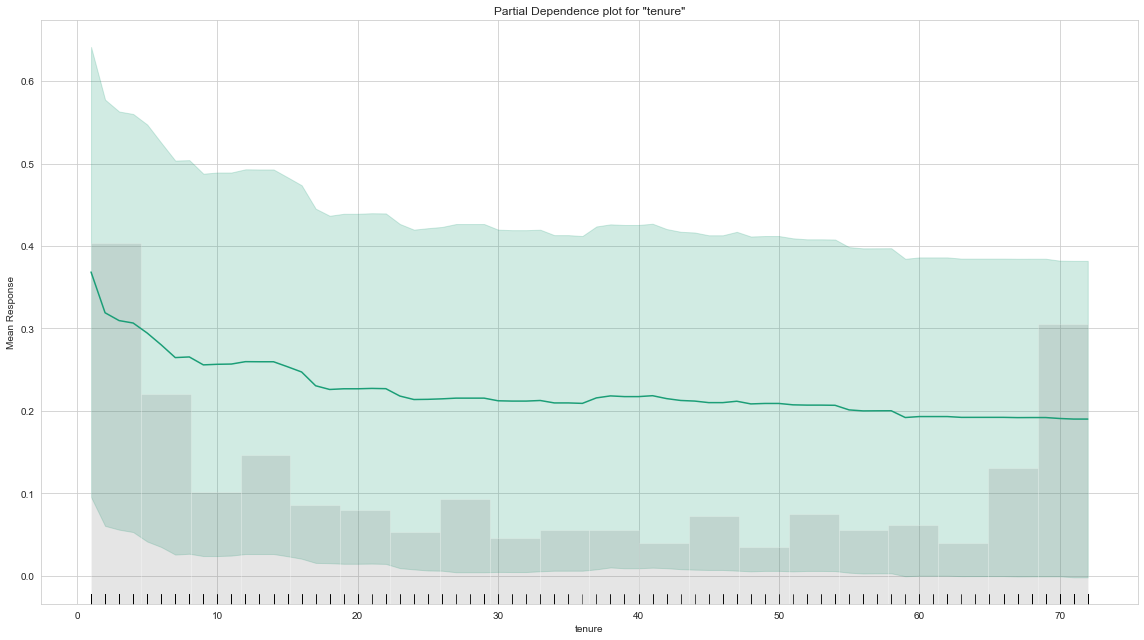

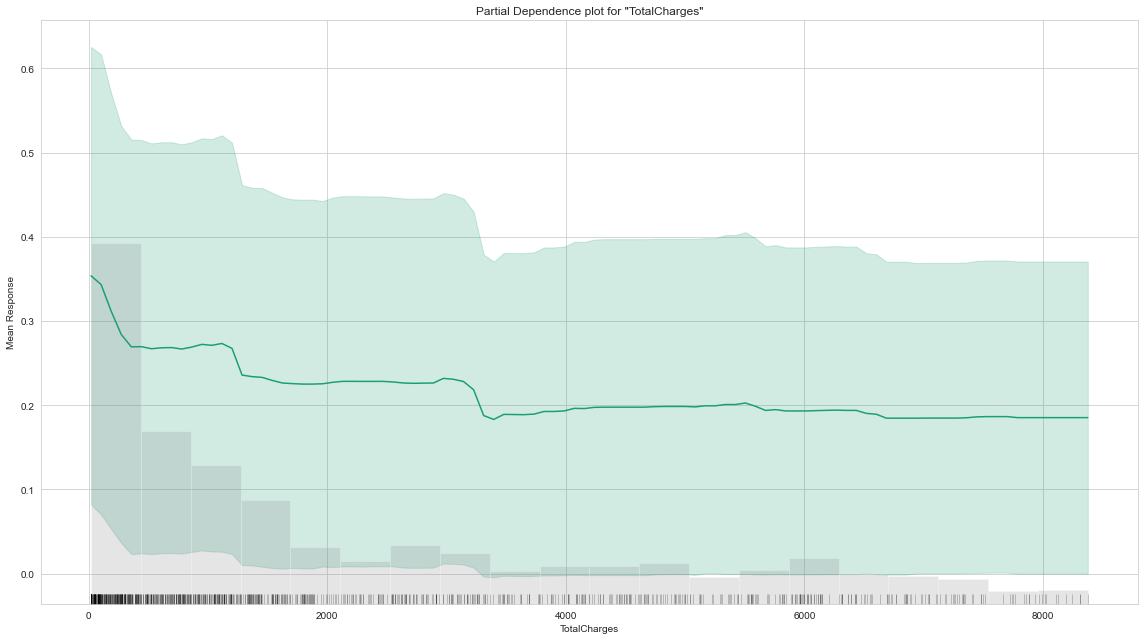

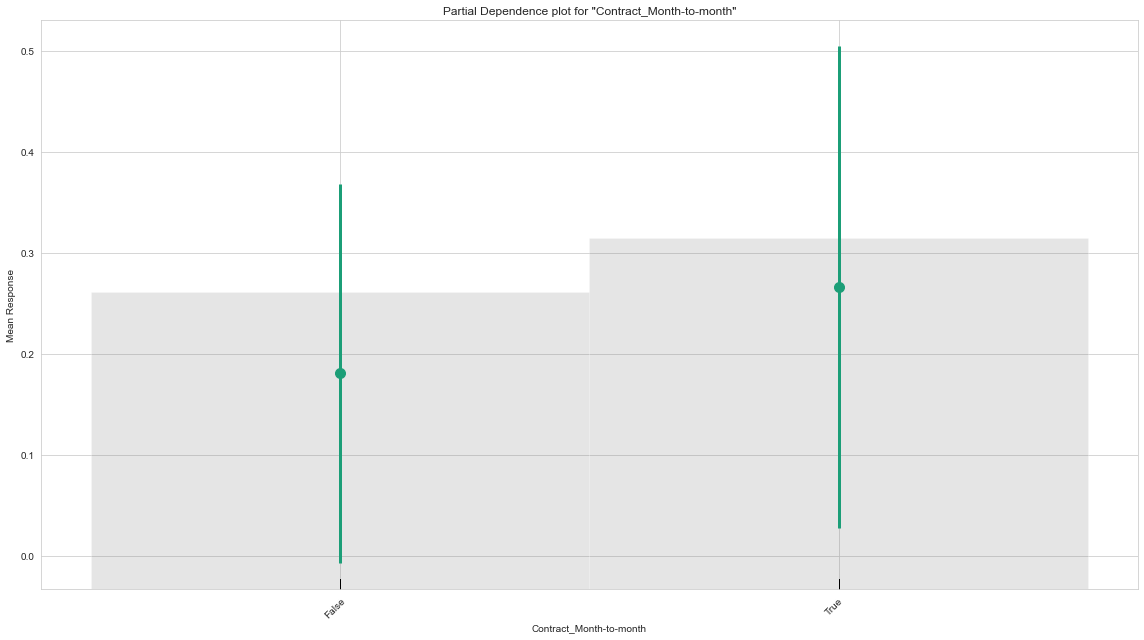

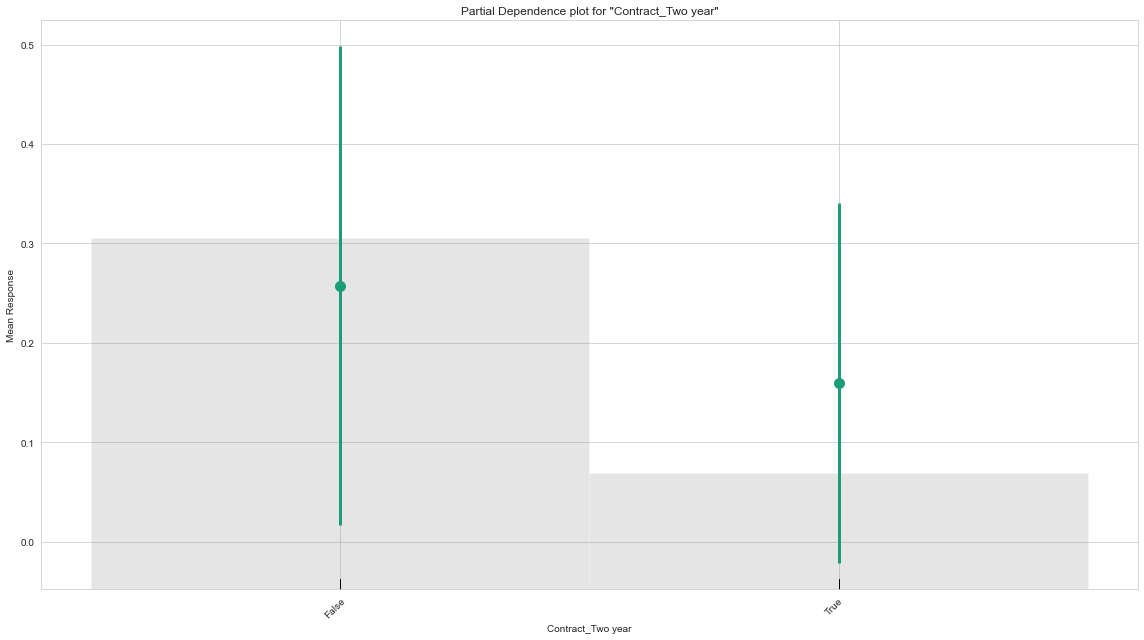

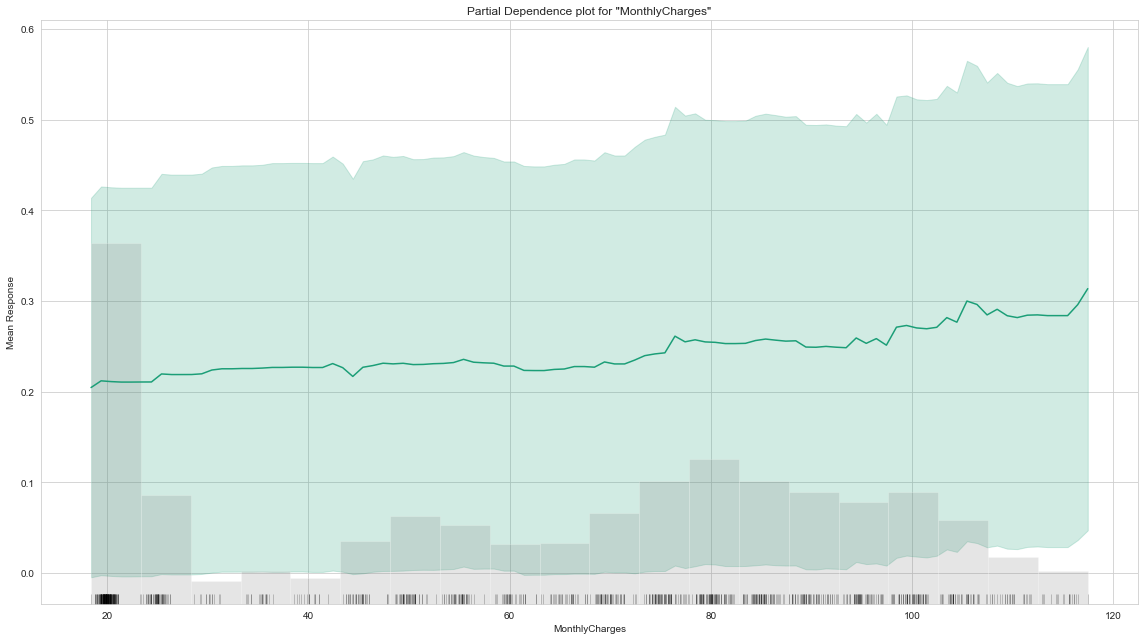

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## random_grid_model_4


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2800889196921385: 


0      1   Error             Rate
0      0  611.0  180.0  0.2276    (180.0/791.0)
1      1   74.0  205.0  0.2652     (74.0/279.0)
2  Total  685.0  385.0  0.2374   (254.0/1070.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [55]:
tuned_gbm.explain(test)

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

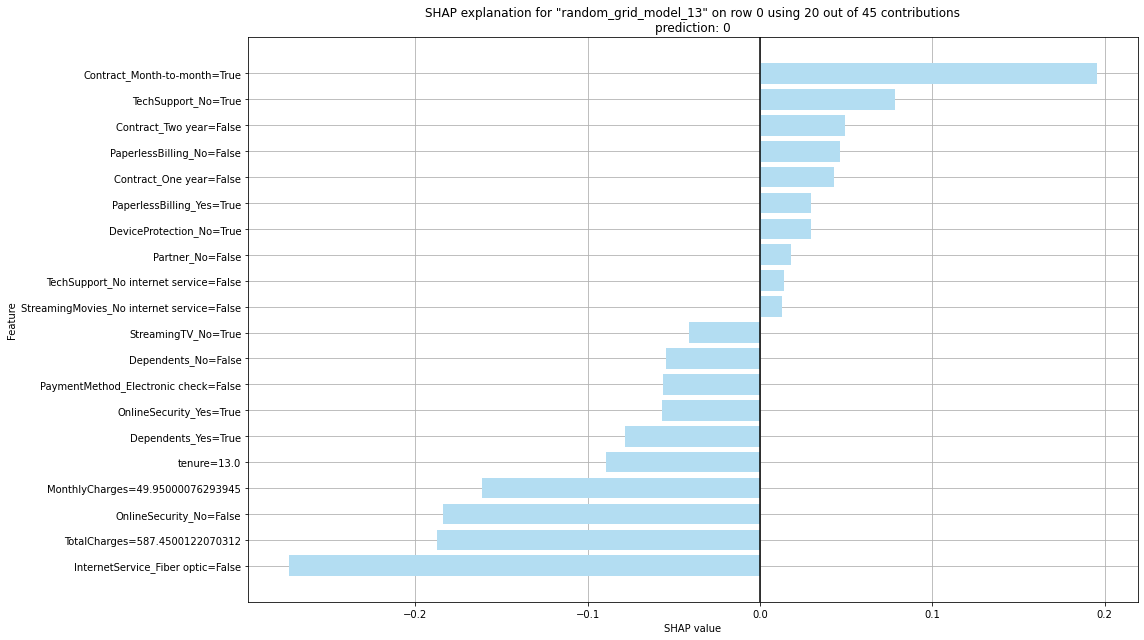

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

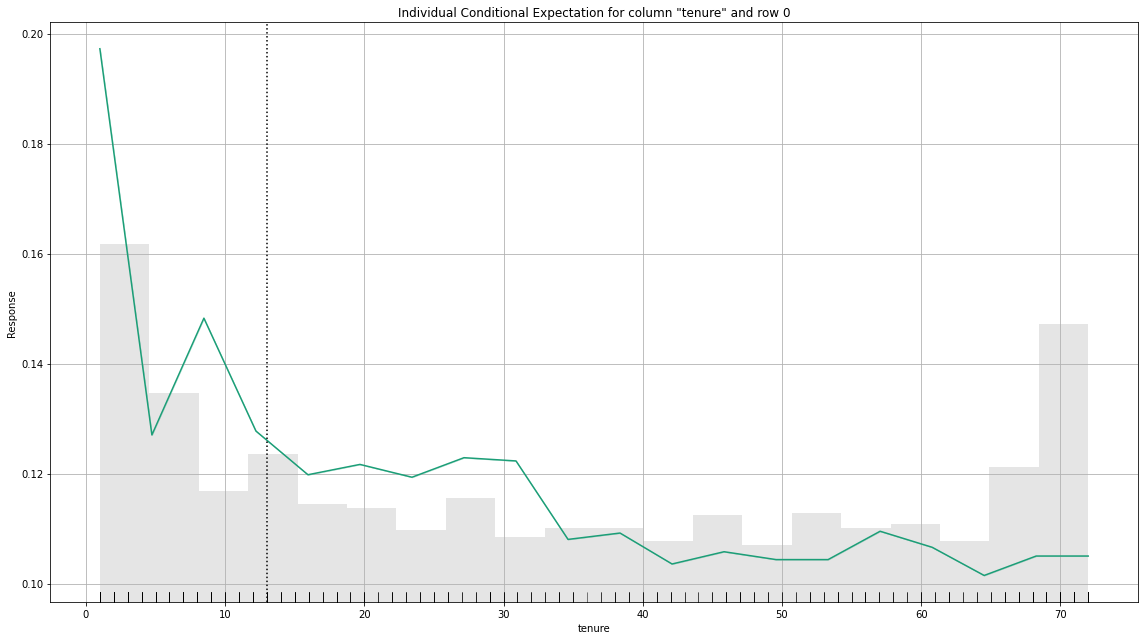

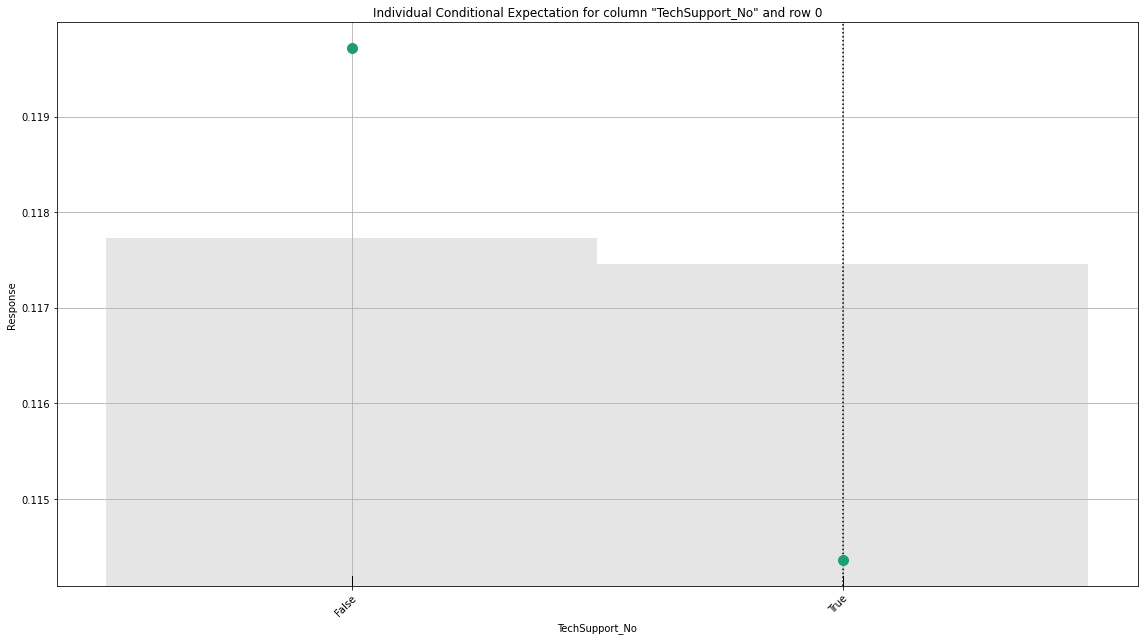

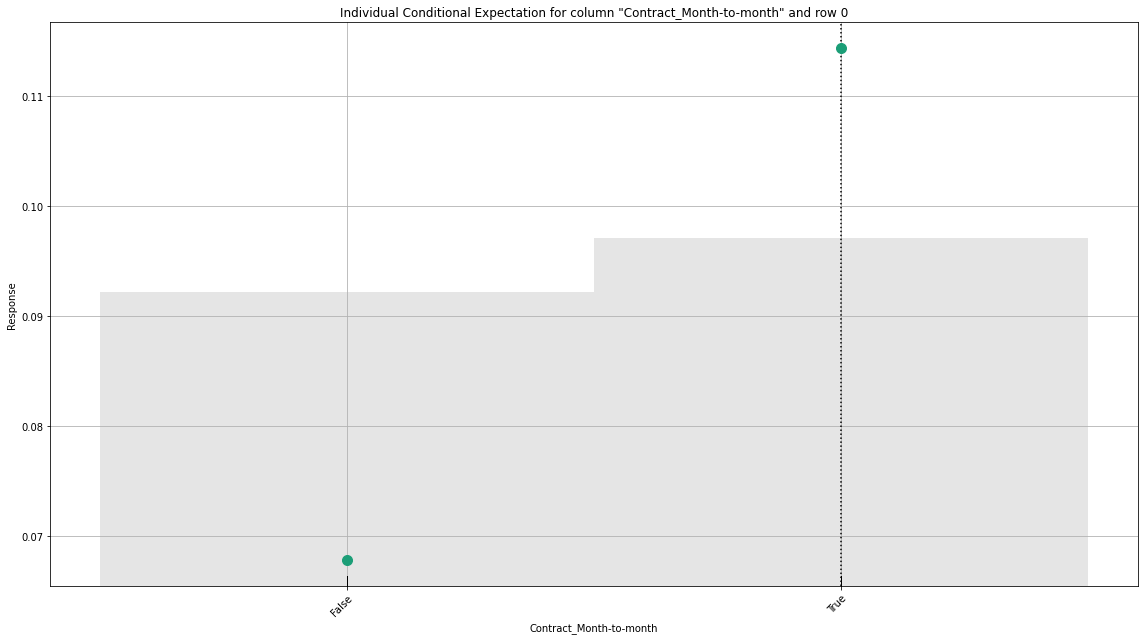

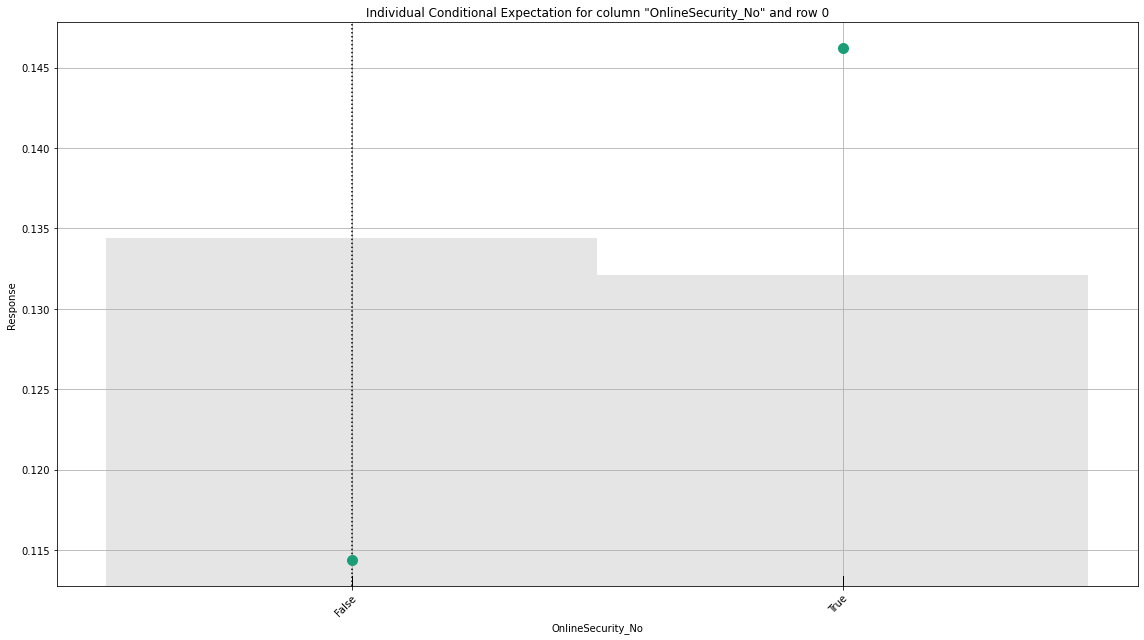

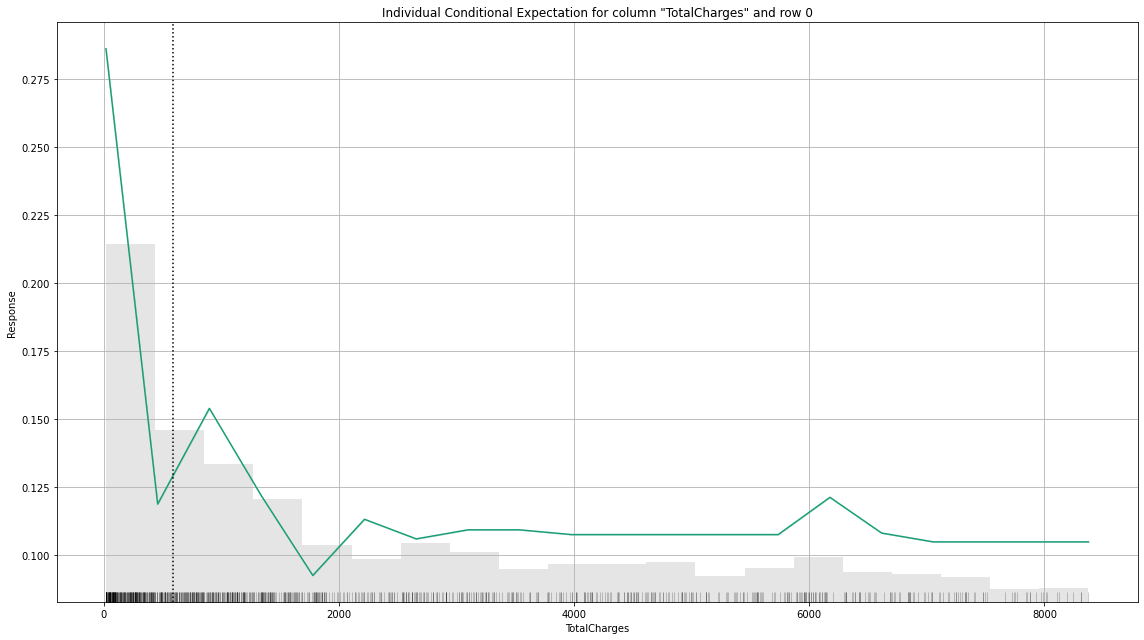

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

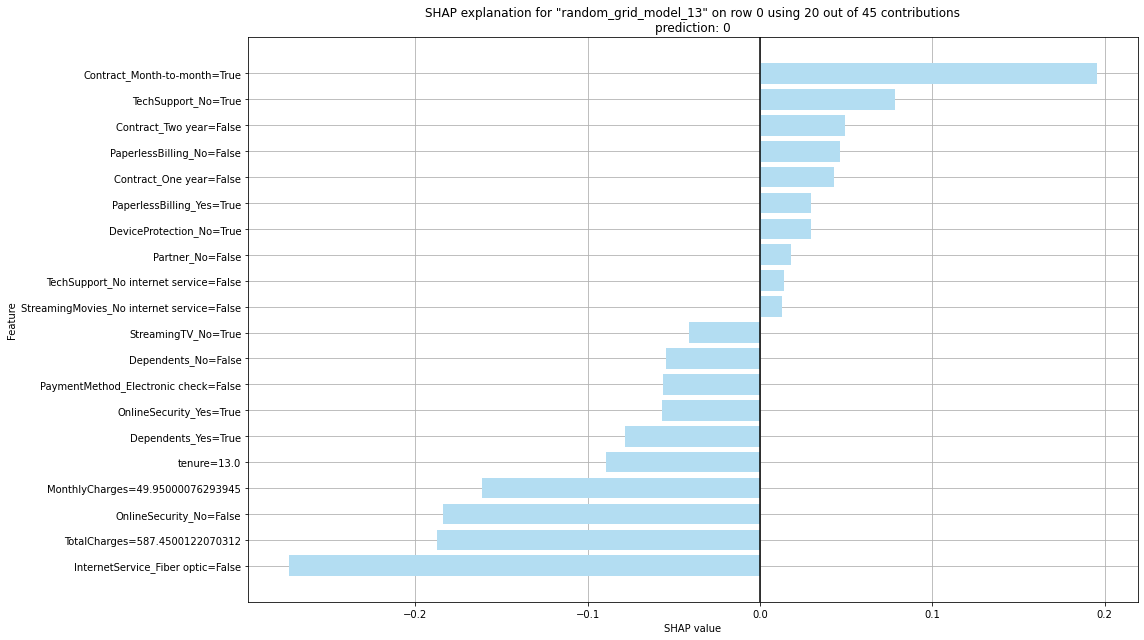

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

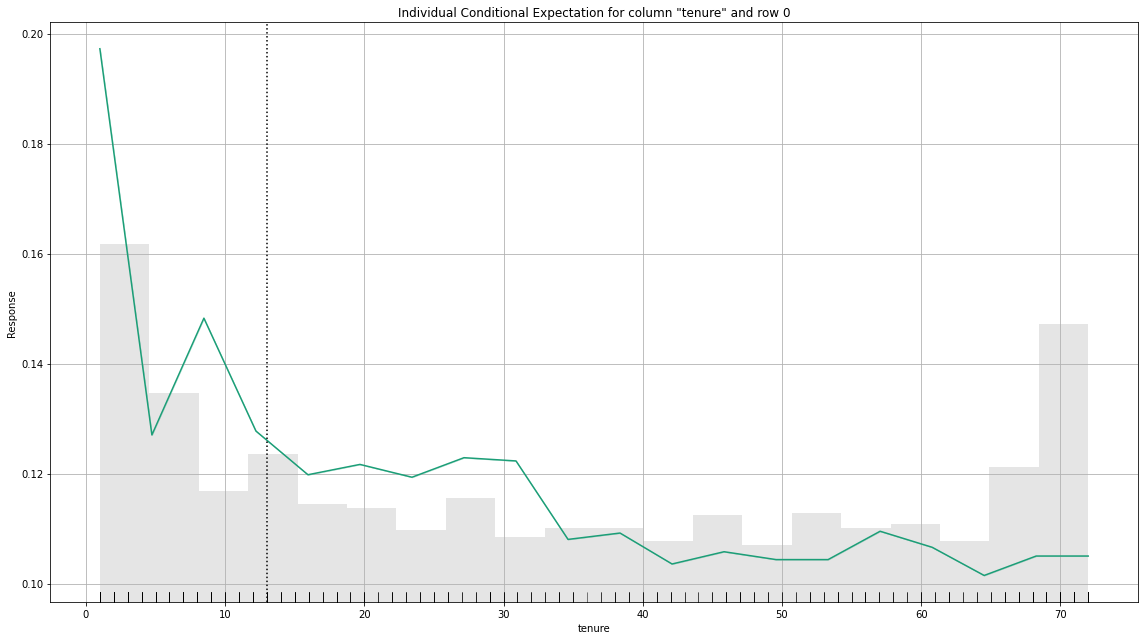

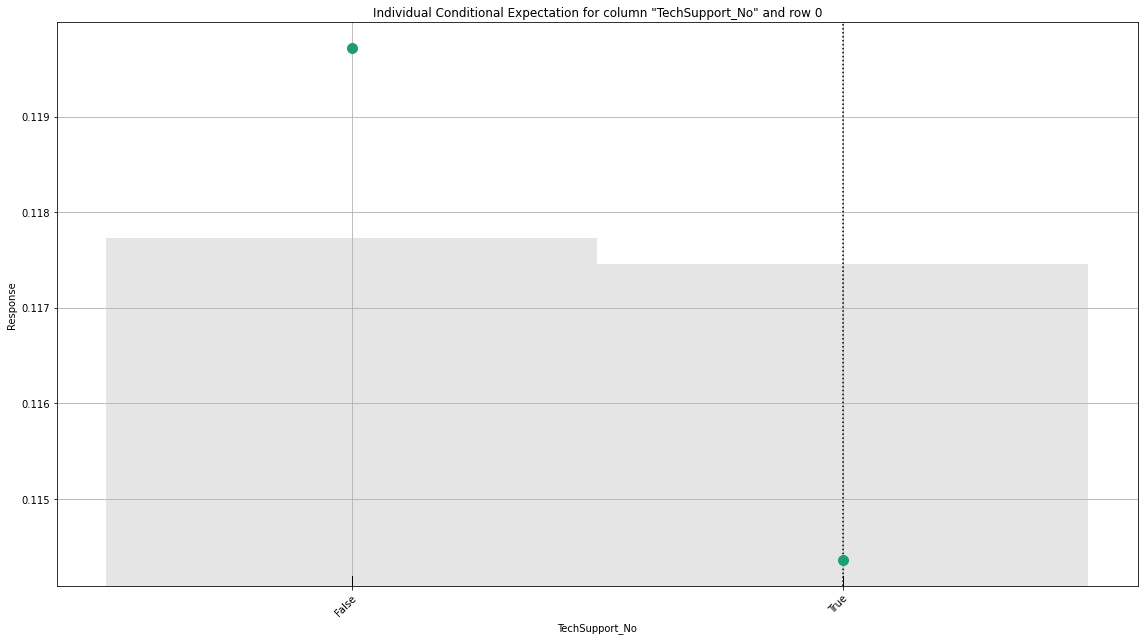

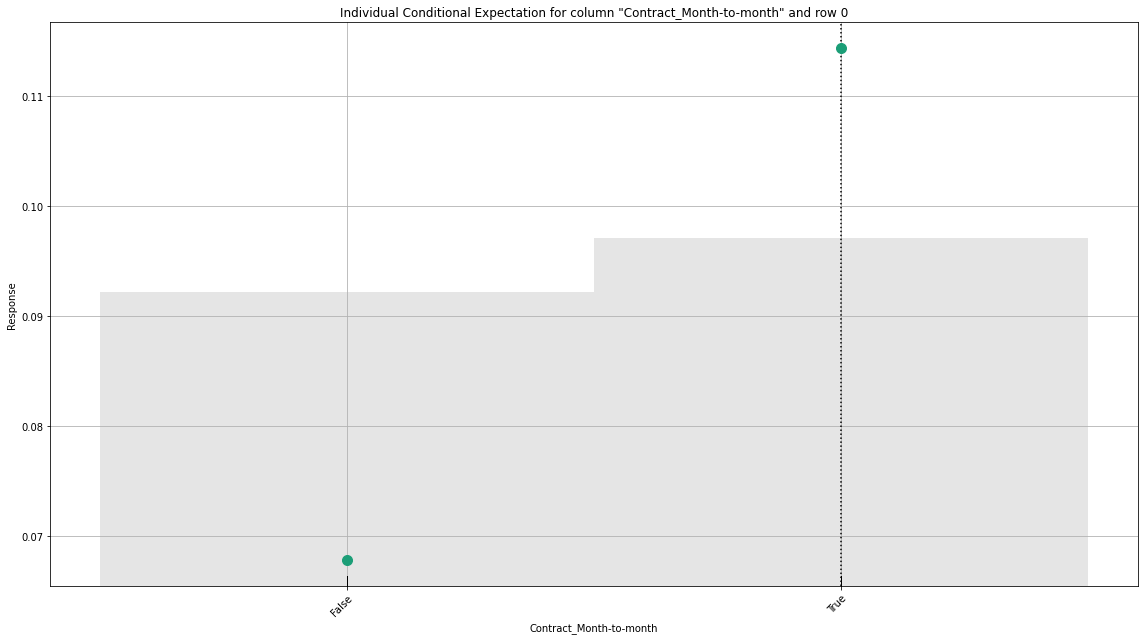

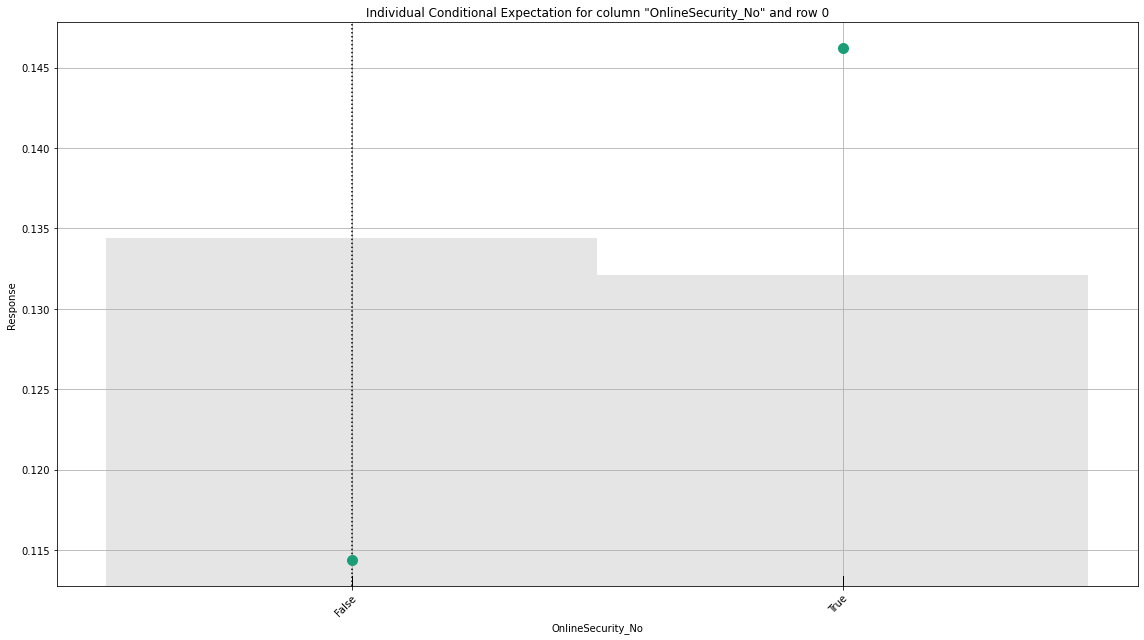

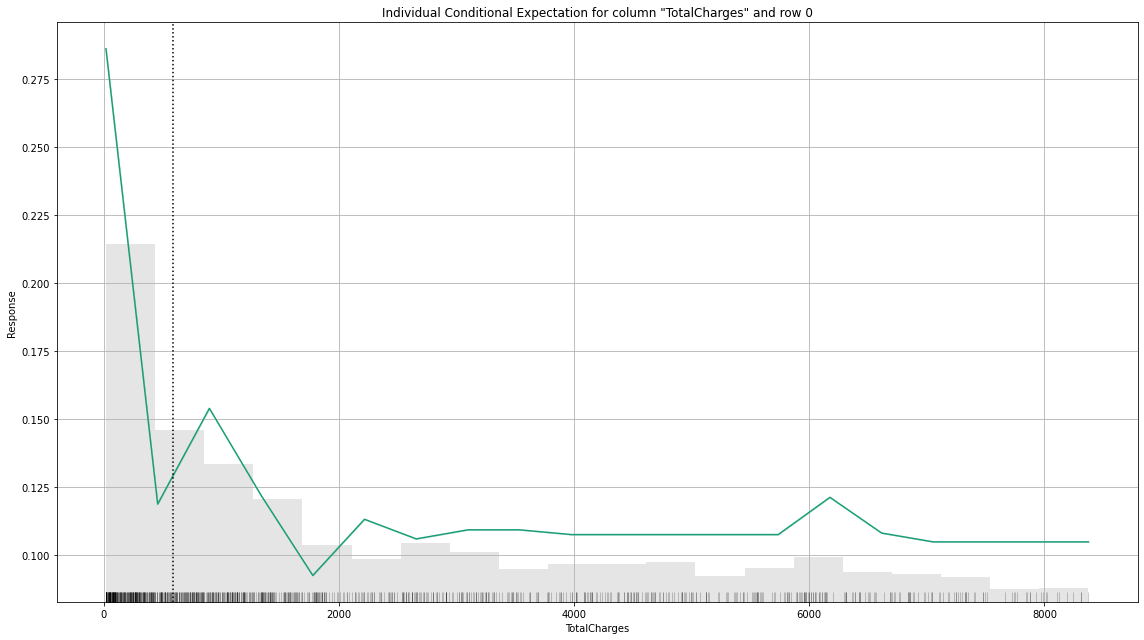

In [62]:
tuned_gbm.explain_row(test, row_index=0)